In [1]:
from survival.io.dataHandler import Config, MetadataHandler, OligosHandler, FeatureManager
from survival.plots.metricsPlots_survival_helpers import *
from survival.plots.plots_helpers import *
from matplotlib.colors import LinearSegmentedColormap
import joblib
from tabulate import tabulate
import math

In [146]:
#config_file = "/home/creyna/Vogl-lab_Projects_git/HCC/Data/Survival/Metadata/config_file_survival.yaml"
config_file = "/home/creyna/Vogl-lab_Projects_git/survival_project/configs/config_survival_HCC.yaml"
config = Config(config_file)
metadata_handler = MetadataHandler(config)
oligos_handler = OligosHandler(config) #, data_type=config.data_types[0])
feature_manager = FeatureManager(config, metadata_handler, oligos_handler,
                                 subgroup = 'all',
                                 with_oligos=True,
                                 with_additional_features = True,
                                 filter_by_entropy=False,
                                 prevalence_threshold_min=0,
                                 prevalence_threshold_max=100)
X_train, y_event_train = feature_manager.get_features_target()
y_time_train = X_train["OS months"]
X_train.drop(columns = ["OS months"], inplace = True)
y_time_train = y_time_train.where(y_event_train == 1, -y_time_train) #np.where(y_event, y_time, -y_time)
number_peptides = X_train.shape[1]
X_train.shape

(73, 8011)

# Antigen score

In [3]:
config.figures_dir = "/home/creyna/Vogl-lab_Projects_git/survival_project/tmp"
out_dir = "/home/creyna/Vogl-lab_Projects_git/survival_project/tmp"
file_path_template = "/home/creyna/Vogl-lab_Projects_git/HCC/Data/Survival/results/nested_XGB-survivalCox_HCC-ICI_{}.joblib"
start, end = 1, 500

In [4]:
# Settings
top_k = 30
min_freq = 0.5
n_select = 15

# Step 1: gather stats
runs_used, feats, freq_counter, rank_sum, rank_n, mean_abs_sum = process_runs_for_stats(
    file_path_template, start, end, top_k
)

# Step 2: hybrid selection
stats_df, selected_df = hybrid_select(
    feats, runs_used, freq_counter, rank_sum, rank_n, mean_abs_sum,
    min_freq=min_freq, n_select=n_select
)

top_peptides_train = selected_df['feature'].values
joblib.dump(top_peptides_train, f"{config.figures_dir}/top_peptides_train.pkl")

Pass 1: stats: 100%|██████████| 500/500 [02:02<00:00,  4.08it/s]

[INFO] Only 13 peptides passed freq ≥ 0.50, relaxing...


['/home/creyna/Vogl-lab_Projects_git/HCC/Data/Survival/antigen_score/top_peptides_train.pkl']

In [5]:
top_peptides_train = joblib.load(f"{out_dir}/top_peptides_train.pkl")
top_peptides_train

array(['agilent_26654', 'twist_58791', 'twist_28586', 'agilent_241214',
       'agilent_225378', 'agilent_73606', 'agilent_7108', 'agilent_11270',
       'twist_63959', 'agilent_198784', 'agilent_225587', 'agilent_98303',
       'agilent_73623', 'agilent_235465', 'agilent_219967'], dtype=object)

In [6]:
selected_df.to_excel(f"{config.figures_dir}/top_peptides_train_HCC-ICI_{number_peptides}.xlsx", index=False)

In [5]:
max_time_point_risk = 25
antigen_scores, auc_antigen_values_train_full, mean_auc_antigen_train_full = compute_antigen_score_from_joblibs(
    file_path_template=file_path_template,
    start = start, end = end,
    time_train=y_time_train, time_test=y_time_train,
    max_timepoint=max_time_point_risk,
    min_timepoint=0,
    top_peptides=top_peptides_train,
    agg="median"
)

Computing per-run antigen scores: 100%|██████████| 500/500 [00:58<00:00,  8.50it/s]


In [6]:
mu  = antigen_scores.mean(skipna=True)
sig = antigen_scores.std(skipna=True)
mu, sig

(0.05584122339834023, 0.48688137631359574)

In [9]:
antigen_scores_df = pd.DataFrame(antigen_scores, columns = ["Antigen Score"])
antigen_scores_df['Antigen Score (Scaled)'] = (antigen_scores - mu) / sig
antigen_scores_df

,Antigen Score,Antigen Score (Scaled)
SampleName,,
R14P01_02_LB_004_02_HCC_MUW_A_T_C2,-0.568551,-1.282431
R14P01_05_LB_009_01_HCC_MUW_A_T_C2,-0.131602,-0.384988
R14P01_06_LB_026_01_HCC_MUW_A_T_C2,-0.309722,-0.750827
R14P01_08_HCCAB_24_02_HCC_MUW_A_T_C2,-0.224568,-0.575930
R14P01_09_HCCAB_27_01_HCC_MUW_A_T_C2,-0.576202,-1.298146
...,...,...
R14P01_68_HCC629_HCC_MUW_A_T_C2,-0.032083,-0.180587
R14P01_70_HCC635_HCC_MUW_A_T_C2,0.373995,0.653452
R14P01_71_HCC681_HCC_MUW_A_T_C2,0.054090,-0.003597


In [8]:
# build tidy DF + threshold + saved CSVs
antigen_scores_df, threshold, raw_csv, with_cut_csv = build_antigen_score_df(
    antigen_score=antigen_scores_df,
    y_time=y_time_train.abs(),   # OS months
    y_event=y_event_train, # 0/1
    out_dir=out_dir,
    save_prefix="antigen_scores_train_RAW",  # customize label
    threshold_method="maxstat",              # or "median"/"percentile"
    percentile=0.5,                          # used only for percentile
    r_seed=1,
    r_B=9999,
)

print("Chosen threshold:", threshold)
print("Saved:", raw_csv, "and", with_cut_csv)
antigen_scores_df

Chosen threshold: -0.2684331
Saved: /home/creyna/Vogl-lab_Projects_git/HCC/Data/Survival/antigen_score/antigen_scores_train_RAW.csv and /home/creyna/Vogl-lab_Projects_git/HCC/Data/Survival/antigen_score/antigen_scores_train_RAW_with_cut.csv


Warning message:
package ‘survival’ was built under R version 4.3.3 


,OS months,OS Status,Antigen Score,Antigen Score (Scaled),Antigen Score (Dichotomized)
SampleName,,,,,
R14P01_02_LB_004_02_HCC_MUW_A_T_C2,38.001315,0,-0.568551,-1.282431,0
R14P01_05_LB_009_01_HCC_MUW_A_T_C2,45.627876,0,-0.131602,-0.384988,0
R14P01_06_LB_026_01_HCC_MUW_A_T_C2,2.958580,0,-0.309722,-0.750827,0
R14P01_08_HCCAB_24_02_HCC_MUW_A_T_C2,11.308350,0,-0.224568,-0.575930,0
R14P01_09_HCCAB_27_01_HCC_MUW_A_T_C2,25.608153,0,-0.576202,-1.298146,0
...,...,...,...,...,...
R14P01_68_HCC629_HCC_MUW_A_T_C2,9.960552,1,-0.032083,-0.180587,1
R14P01_70_HCC635_HCC_MUW_A_T_C2,2.859961,1,0.373995,0.653452,1
R14P01_71_HCC681_HCC_MUW_A_T_C2,1.347798,1,0.054090,-0.003597,1


In [11]:
#config.figures_dir =  "/home/creyna/Vogl-lab_Projects_git/HCC/Reports/plots/Figure5"
config.figures_dir = "/home/creyna/Vogl-lab_Projects_git/survival_project/tmp"

In [12]:
antigen_scores_df.to_excel(f"{config.figures_dir}/antigen_scores_train_HCC-ICI_{number_peptides}.xlsx", index=True)

## SHAP values

In [ ]:
shap_values =  pd.DataFrame(0.0, index=X_train.index, columns=X_train.columns)

for i in range(start, end+1):
    # Construct the file path for the model results based on its ID/seed.
    file_path = file_path_template.format(i)
    results = load(file_path)
    shap_values += results['train_shap_values']

shap_values /= end

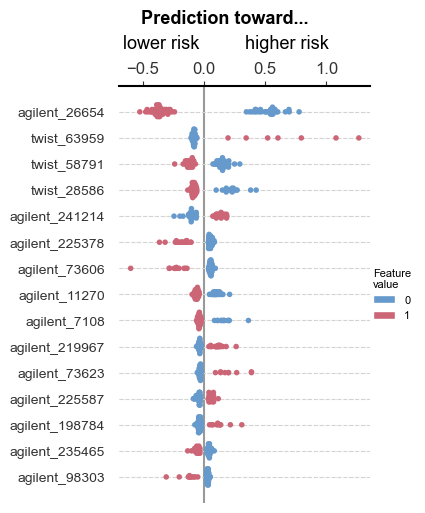

In [21]:
newCmap = LinearSegmentedColormap.from_list("", ['#6699CC', '#CC6677'])
shap_fontsize = {
        'xlabel': 13,
        'ylabel': 13,
        'xticks': 12,
        'yticks': 10,
        'legend': 8,
        'colorbar': 12
}

f, a = plot_shap_values(shap_values.loc[:,top_peptides_train].values, X_train.loc[:,top_peptides_train],
                        cmap=newCmap, max_display=15, figure_size = (5,5), fontsize  = shap_fontsize,
                        add_group_labels=True, x_label = "Prediction toward...", group_tests=['lower risk', 'higher risk'],
                        add_binary_legend=True, legend_labels = ['0', '1'], legend_title = "Feature\nvalue",
                        filename_label=f'nestedCV_{number_peptides}_test',
                        save_fig=True, figures_dir=config.figures_dir)
f

In [46]:
oligos_metadata = pd.read_pickle("/home/creyna/Vogl-lab_Projects_git/HCC/Data/Survival/Metadata/combined_libraries_with_lineages_important_info_nonAAseq.pkl")
oligos_metadata = oligos_metadata[['Description', 'species', 'genus', 'family','order']]
feature_importance_train = generate_feature_importance_table(shap_values.loc[:,top_peptides_train], X_train.loc[:,top_peptides_train], y_event_train, oligos_metadata,
                                                             group_tests = config.group_tests, filename_label=f'nested-HCC-ICI_{number_peptides}', figures_dir = f"{config.figures_dir}")
feature_importance_train

,Peptide ID,SHAP value,Description,Species,Genus,Family,Order,censored,deceased,Ratio
0,agilent_26654,0.430812,N-acetylmuramoyl-L-alanine amidase sle1,Staphylococcus aureus,Staphylococcus,Staphylococcaceae,Bacillales,78.125,46.341463,1.685855
1,twist_63959,0.139668,hypothetical phage protein,Firehammervirus CPt10,Firehammervirus,NaN,NaN,6.250,12.195122,0.512500
2,twist_58791,0.137440,Rhinovirus B Genome polyprotein,Rhinovirus B,Enterovirus,Picornaviridae,Picornavirales,50.000,41.463415,1.205882
3,twist_28586,0.120665,Rhinovirus B Genome polyprotein,Rhinovirus B,Enterovirus,Picornaviridae,Picornavirales,90.625,63.414634,1.429087
4,agilent_241214,0.117638,Surface protein PspC,Streptococcus pneumoniae,Streptococcus,Streptococcaceae,Lactobacillales,40.625,48.780488,0.832812
5,agilent_225378,0.090412,Surface protein A,Streptococcus pneumoniae,Streptococcus,Streptococcaceae,Lactobacillales,43.750,14.634146,2.989583
6,agilent_73606,0.086622,Endolytic murein transglycosylase,uncultured Ruminococcus sp.,Ruminococcus,Oscillospiraceae,Eubacteriales,31.250,4.878049,6.406250
7,agilent_11270,0.077611,NaN,Enterovirus B,Enterovirus,Picornaviridae,Picornavirales,59.375,56.097561,1.058424
8,agilent_7108,0.060932,Genome polyprotein,Rhinovirus B,Enterovirus,Picornaviridae,Picornavirales,93.750,75.609756,1.239919
9,agilent_219967,0.058978,GRAB,Streptococcus pyogenes,Streptococcus,Streptococcaceae,Lactobacillales,21.875,31.707317,0.689904


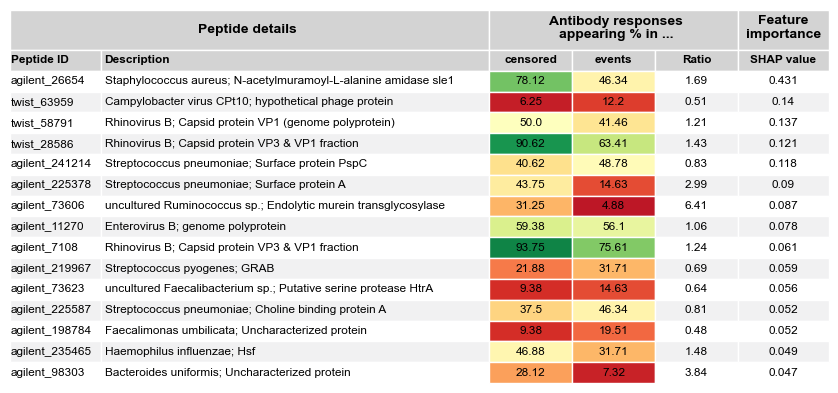

In [28]:
group_tests = ['censored', 'events']
feature_importance_train = pd.read_csv(f'{config.figures_dir}/Table_shap_censored-deceased_nested-HCC-ICI_8011_with_oligos.csv')
#and make the font size bigger for the content of Peptide ID, Description, Contrls, HCC, Ratio and SHAP value columns,
f, a = plot_table_top_features(feature_importance_train,
                        to_select_features = 15,
                        fig_size=(8.5, 4),
                        group_tests = group_tests,
                        figure_dir = config.figures_dir, filename_label=f"{'-'.join(group_tests)}_test_HCC-TKI", save_fig = True)
f

## Kaplan Meier

INFO:survival.plots.metricsPlots_survival_helpers:Figure saved to /home/creyna/Vogl-lab_Projects_git/survival_project/tmp/kaplan_meier_nestedCV_HCC-ICI_8011_scaled_newcolors.pdf
INFO:survival.plots.metricsPlots_survival_helpers:Log-Rank Test p-value: 0.0000


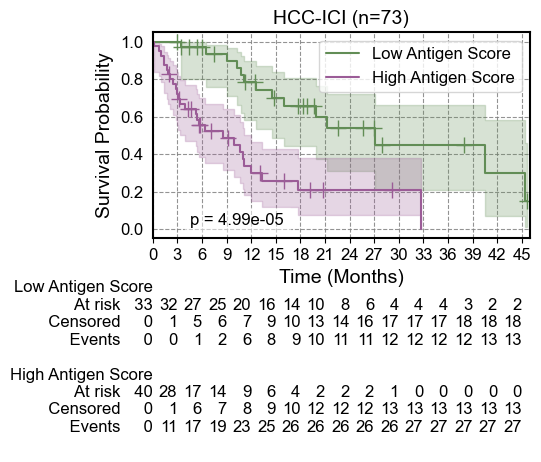

In [31]:
# Assuming the antigen score has been dichotomized into "Antigen Score (Dichotomized)" and you have time and event data in a data frame
labels = {0: 'Low Antigen Score', 1: 'High Antigen Score'}

# Plot for Training Set
f, a = plot_kaplan_meier(antigen_scores_df, 'OS months', 'OS Status', 'Antigen Score (Dichotomized)',
                         title="HCC-ICI (n=73)", xlabel="Time (Months)", ylabel="Survival Probability",
                         labels = labels,
                         color_lines = ["#628D56", "#9B5C97"], tick_space=3, loc_legend='best',
                         save_fig=True, figures_dir=config.figures_dir,
                         suffix_file=f'nestedCV_HCC-ICI_{number_peptides}_scaled_newcolors' )


# Perform log-rank test for Training Set
perform_logrank_test(antigen_scores_df, 'OS months', 'OS Status', 'Antigen Score (Dichotomized)')
f

# Time-dependent AUC

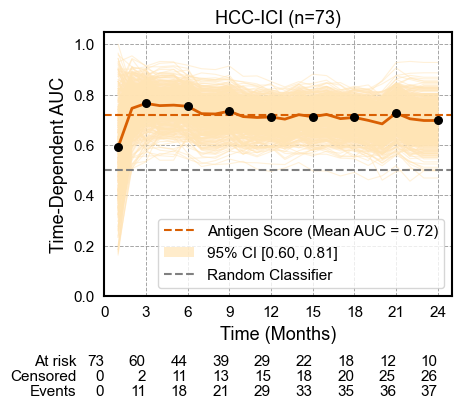

In [49]:
max_time_point_plot = 25
auc_matrix = auc_antigen_values_train_full.copy()

# 95% pointwise CI across runs
ci_lower = auc_matrix.quantile(0.025, axis=0).values
ci_upper = auc_matrix.quantile(0.975, axis=0).values
ci_lower   = np.asarray(ci_lower, dtype=float)
ci_upper   = np.asarray(ci_upper, dtype=float)
# Mean of per-run mean tAUCs for legend label
# (mean_time_dependent_auc: length-500 Series you already computed)

time_points_highlight_train = np.concatenate(([1], np.arange(3, max_time_point_risk, step=3)))
extension_time_points = np.arange(0, max_time_point_plot, step=3)
samples_at_risk_train = calculate_samples_at_risk(y_time_train, extension_time_points)

fig = plot_time_dependent_auc(auc_matrix, samples_at_risk_train,
                        mean_auc=mean_auc_antigen_train_full,
                        ci_lower=ci_lower, ci_upper=ci_upper,
                        extension_time_points = extension_time_points,
                        time_points_highlight=time_points_highlight_train,
                        time_measure = "Months", max_time_point = max_time_point_plot,
                        color_auc = "#d95f02", color_mean="#d95f02", color_ci="moccasin",
                        run_lines_color = "moccasin", run_lines_alpha = 0.5,
                        figures_dir = config.figures_dir, save_fig=False)




ax_auc = fig.get_axes()[0]
# Assign new legend
ax_auc.set_title("HCC-ICI (n=73)", fontsize=13)
save_path = Path(config.figures_dir) / f'time-dependent_auc_nestedHCC-ICI_{number_peptides}_scaled.pdf'
fig.set_size_inches(4.5, 4)
plt.savefig(save_path, dpi=600, bbox_inches='tight')
fig

# Load Metadata

In [50]:
antigen_scores_time_event_train = antigen_scores_df
top_peptides_df = feature_manager.get_data_with_target()[top_peptides_train].droplevel(0)
clinical_meta = metadata_handler.get_individuals_metadata_df()
clinical_meta = pd.concat([clinical_meta,
                         pd.concat([antigen_scores_time_event_train.iloc[:,2:]], axis=1, names=["SampleName"]), top_peptides_df],  axis = 1)
# Replace 1 with the name of the peptide and 0 with "absence"
for peptide_column in top_peptides_train:
    clinical_meta[peptide_column] = clinical_meta[peptide_column].apply(
        lambda x: 'presence' if x == 1 else 'absence'
    )
clinical_meta['Sex_ctg'] = clinical_meta['Sex'].apply(lambda x: "Male" if x == 1 else "Female")

clinical_meta['Age_ctg'] = clinical_meta['Age'].apply(lambda x: ">=65" if x >=65 else "<65")

clinical_meta['AFP 100_ctg'] = clinical_meta['AFP'].apply(lambda x: ">=100" if x >=100 else "<100")
clinical_meta['AFP 400_ctg'] = clinical_meta['AFP'].apply(lambda x: ">=400" if x >=400 else "<400")

clinical_meta["Line_of_syst.treatment"] = pd.get_dummies(clinical_meta["Line_of_syst.treatment_ctg"], drop_first=True, dtype=int)

clinical_meta["BMI Category"] = clinical_meta["BMI"].apply(lambda x: "<18.5" if x < 18.5 else
                                                        ">=18.5<25" if 18.5 <= x < 25 else
                                                        ">=25<30" if 25 <= x < 30 else
                                                        ">=30<35" if 30 <= x < 35 else
                                                        ">=35")
clinical_meta = pd.concat([clinical_meta, pd.get_dummies(clinical_meta["BMI Category"], drop_first=False, dtype=int).drop(columns=[">=18.5<25"])], axis =1)

clinical_meta['Cirrhosis_ctg'] = clinical_meta['Cirrhosis_ctg'].apply(lambda x: "cirrhosis" if x == "yes" else "no cirrhosis")
clinical_meta['Cirrhosis_ctg'] = pd.Categorical(clinical_meta['Cirrhosis_ctg'],
                                                     categories=["no cirrhosis","cirrhosis"], ordered=True)

clinical_meta = pd.concat([clinical_meta, pd.get_dummies(clinical_meta["Child-Pugh stage_ctg"], drop_first=True, dtype=int).rename(columns={"stage B": "Child-Pugh stage B"})], axis=1)
clinical_meta['MVI_ctg'] = clinical_meta['MVI_ctg'].apply(lambda x: "MVI" if x == "yes" else "no MVI")
clinical_meta['MVI_ctg'] = pd.Categorical(clinical_meta['MVI_ctg'],
                                                     categories=["no MVI","MVI"], ordered=True)
clinical_meta['EHS_ctg'] = clinical_meta['EHS_ctg'].apply(lambda x: "EHS" if x == "yes" else "no EHS")
clinical_meta['EHS_ctg'] = pd.Categorical(clinical_meta['EHS_ctg'],
                                                     categories=["no EHS","EHS"], ordered=True)

# Merge "stage A" and "stage B" into "stage AB"
clinical_meta['BCLC stage_ctg'] = clinical_meta['BCLC stage_ctg'].replace({'stage A': 'stage AB', 'stage B': 'stage AB'})
clinical_meta['BCLC stage_ctg'] = pd.Categorical(clinical_meta['BCLC stage_ctg'],
                                                     categories=["stage AB", "stage C"], ordered=True)
clinical_meta = pd.concat([clinical_meta, pd.get_dummies(clinical_meta["BCLC stage_ctg"], drop_first=True, dtype=int).rename(columns={"stage C": "BCLC stage C"})], axis=1)

clinical_meta['Antigen Score (Dichotomized) ctg'] = clinical_meta['Antigen Score (Dichotomized)'].apply(lambda x: "Low Antigen Score" if x == 0 else "High Antigen Score")
clinical_meta['Antigen Score (Dichotomized) ctg'] = pd.Categorical(clinical_meta['Antigen Score (Dichotomized) ctg'],
                                                     categories=["Low Antigen Score", "High Antigen Score"], ordered=True)

clinical_meta = pd.concat([clinical_meta, pd.get_dummies(clinical_meta["mRECIST_ctg"], drop_first=True, dtype=int)], axis = 1)
clinical_meta

,Etiology,treatment,subtreatment,group_test,Sex,Age,Centre,ORR,ORR_ctg,DCR,...,<18.5,>=25<30,>=30<35,>=35,Child-Pugh stage B,BCLC stage C,Antigen Score (Dichotomized) ctg,PD,PR,SD
SampleName,,,,,,,,,,,,,,,,,,,,,
R14P01_32_HCC3_HCC_MUW_A_T_C2,Alcohol,ICI,ICI,HCC,1,54.953425,Vienna,1.0,ORR,1.0,...,0,1,0,0,1,1,High Antigen Score,0,1,0
R14P01_33_HCC25_HCC_MUW_A_T_C2,Other,ICI,ICI,HCC,1,71.169863,Vienna,1.0,ORR,1.0,...,0,0,0,0,0,1,Low Antigen Score,0,1,0
R14P01_34_HCC27_HCC_MUW_A_T_C2,Viral,ICI,ICI,HCC,1,64.531507,Vienna,0.0,non ORR,0.0,...,0,0,0,0,0,1,High Antigen Score,1,0,0
R14P01_35_HCC134_HCC_MUW_A_T_C2,Alcohol,ICI,ICI,HCC,1,66.438356,Vienna,0.0,non ORR,0.0,...,0,1,0,0,0,1,High Antigen Score,1,0,0
R14P01_36_HCC268_HCC_MUW_A_T_C2,Viral,ICI,ICI,HCC,0,63.997260,Vienna,0.0,non ORR,0.0,...,0,0,1,0,1,1,High Antigen Score,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R14P01_02_LB_004_02_HCC_MUW_A_T_C2,Viral,ICI,e_ICI,HCC,1,86.000000,Hamburg,1.0,ORR,1.0,...,0,0,0,0,0,1,Low Antigen Score,0,0,0
R14P01_03_LB_005_01_HCC_MUW_A_T_C2,Viral,ICI,e_ICI,HCC,1,62.000000,Hamburg,1.0,ORR,1.0,...,1,0,0,0,0,1,Low Antigen Score,0,0,0
R14P01_04_LB_006_01_HCC_MUW_A_T_C2,Viral,ICI,e_ICI,HCC,1,68.000000,Hamburg,0.0,non ORR,1.0,...,0,0,0,0,1,1,High Antigen Score,0,0,1


In [51]:
df = pd.read_pickle("/home/creyna/Vogl-lab_Projects_git/Annotations/combined_libraries_with_lineages_important_info_withFullAAseq.pkl")
df

,pos,len_seq,full name,Description,is_IEDB_or_cntrl,is_auto,is_infect,is_EBV,is_toxin,is_PNP,...,order,family,genus,species,common,allergens_species,allergens_common_name,allergens_comments,aa_seq,full_aa_seq
agilent_0,0,0.0,FLAG-tag control,NaN,True,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,False,False,False,DYKDDDDK,DYKDDDDK
agilent_1,2728,2997.0,Chromodomain-helicase-DNA-binding protein 7,Chromodomain-helicase-DNA-binding protein 7,True,True,False,False,False,False,...,Primates,Hominidae,Homo,Homo sapiens,Human,False,False,False,AAAAAAVASTSGINPLLVNSLFAGMDLTSLQNLQNLQSLQLAGLMG...,MADPGMMSLFGEDGNIFSEGLEGLGECGYPENPVNPMGQQMPIDQG...
agilent_2,88,445.0,integral membrane protein,Uncharacterized MFS-type transporter Rv2994,True,False,True,False,False,False,...,Mycobacteriales,Mycobacteriaceae,Mycobacterium,Mycobacterium tuberculosis,NaN,False,False,False,AAAAYAAASVHSLLWIGVFLFLGGMAAGGCNSAGGRLVSGWFPPQQ...,MSRDPTGVGARWAIMIVSLGVTASSFLFINGVAFLIPRLENARGTP...
agilent_3,264,548.0,hypothetical protein (6/16) & membrane protein...,Possible conserved membrane protein,True,False,True,False,False,False,...,Mycobacteriales,Mycobacteriaceae,Mycobacterium,Mycobacterium tuberculosis,NaN,False,False,False,AAADRSAPLSRRSLLIGNAVVAFAVIGFASLAVAVAVTIRPTAASK...,MDVALGVAVTDRVARLALVDSAAPGTVIDQFVLDVAEHPVEVLTET...
agilent_4,1276,3432.0,envelope protein (5/8) & anchored core protein...,Genome polyprotein,True,False,True,False,False,False,...,Amarillovirales,Flaviviridae,Orthoflavivirus,Orthoflavivirus japonicum,JEV,False,False,False,AAAIAWMIVRAITFPTTSSVTMPVLALLTPGMRALYLDTYRIILLV...,MTKKPGGPGKNRAINMLKRGLPRVFPLVGVKRVVMSLLDGRGPVRF...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
corona2_13187,0,0,random sequence 37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TGGILDDMLLDMPQRFASVHHIMCTFMSPGTVDCVRQEMDMNYWSQ...,NaN
corona2_13188,0,0,random sequence 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TWHSPHVMHVPQSNQHKDLYYVSGYDVRMEQQPLTTQNQMFVNWWS...,NaN
corona2_13189,0,0,random sequence 17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VIQTMHQNTWYVPVRAEERGFYSCMTLIGIPDWFYFDIRSRNCFPG...,NaN
corona2_13190,0,0,random sequence 10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WDVNDCSNNRKTKNPAGHNPCANFPYGGKWNLWDSFERFELPIMTM...,NaN


# Univariate analysis

In [52]:
# Define your list of variables (including any top peptides if needed)
variables = [
    "Sex_ctg", "Age_ctg", "ORR_ctg", "DCR_ctg", "Line_of_syst.treatment_ctg",
    "Cirrhosis_ctg", "Child-Pugh stage_ctg", "ECOG_ctg", "MVI_ctg", "EHS_ctg", "BCLC stage_ctg",
    "AFP 100_ctg", "AFP 400_ctg", "Antigen Score (Dichotomized) ctg",
    *list(top_peptides_train)  # assuming top_peptides_train is defined
]

# Run the univariate analysis function
univariate_results, univariate_kmf  = run_univariate_km_analysis(clinical_meta, variables, out_dir, f"{number_peptides}")

# Now univariate_results is a DataFrame summarizing the key findings.
#print(univariate_results)
print(tabulate(univariate_kmf, headers='keys', tablefmt='latex', showindex=False))
significant_predictors_kmf = univariate_results[univariate_results["P-value"] < 0.1]["Variable"].unique().tolist()
significant_predictors_kmf

\begin{tabular}{llrrrrl}
\hline
 Variable                  & Group        &   Size &   Median OS (Months) &   95\% CI Lower &   95\% CI Upper & P-value         \\
\hline
 Sex                       & Female       &     18 &                10.78 &           6.41 &         inf    &                 \\
                           & Male         &     55 &                14.6  &          10.22 &          27.09 & 0.8951          \\
 Age                       & \ensuremath{<}65          &     23 &                11.11 &           8.58 &          45.36 &                 \\
                           & \ensuremath{>}=65         &     50 &                14.6  &           9.96 &          27.09 & 0.8594          \\
 \textbackslash{}textbf\{ORR\}              & ORR          &     23 &                27.09 &          11.11 &          45.36 &                 \\
                           & non ORR      &     50 &                10.98 &           5.36 &          16.04 & \textbackslash{}textbf\{0.0020\}

['ORR',
 'DCR',
 'Child-Pugh stage',
 'MVI',
 'AFP 100',
 'AFP 400',
 'Antigen Score',
 'agilent_26654',
 'twist_58791',
 'twist_28586',
 'agilent_241214',
 'agilent_225378',
 'agilent_73606',
 'agilent_7108',
 'twist_63959',
 'agilent_198784',
 'agilent_225587',
 'agilent_98303',
 'agilent_73623',
 'agilent_235465']

In [55]:
univariate_kmf

,Variable,Group,Size,Median OS (Months),95% CI Lower,95% CI Upper,P-value
0,Sex,Female,18,10.78,6.41,inf,
1,,Male,55,14.60,10.22,27.09,0.8951
2,Age,<65,23,11.11,8.58,45.36,
3,,>=65,50,14.60,9.96,27.09,0.8594
4,\textbf{ORR},ORR,23,27.09,11.11,45.36,
5,,non ORR,50,10.98,5.36,16.04,\textbf{0.0020}
6,\textbf{DCR},DCR,44,21.20,11.08,45.36,
7,,non DCR,29,9.11,2.86,14.60,\textbf{0.0010}
8,Line_of_syst.treatment,first,64,14.60,9.96,21.20,
9,,later,9,13.38,2.50,40.53,0.5002


In [56]:
univariate_kmf.to_excel(f"{config.figures_dir}/univariate_kmf_HCC-ICI_{number_peptides}.xlsx", index=False)

In [30]:
predictors_cont = ["Age", "AFP", "Antigen Score"]

# predictors for categorical variables:
predictors_ctg = {
    "Sex_ctg": "Female",
    "Age_ctg": "<65",
    "ORR_ctg": "ORR",
    "DCR_ctg": "DCR",
    "Line_of_syst.treatment_ctg": "first",
    "Cirrhosis_ctg": "no cirrhosis",
    "Child-Pugh stage_ctg": "A",
    "ECOG_ctg": "no symptoms",
    "MVI_ctg": "no MVI",
    "EHS_ctg": "no EHS",
    "BCLC stage_ctg": "AB",
    "AFP 100_ctg": "<100",
    "AFP 400_ctg": "<400",
    "Antigen Score (Dichotomized) ctg": "Low"
}
predictors_ctg.update({variable: "absence" for variable in list(top_peptides_train)})

# Run the univariate analysis:
univariate_results, univariate_cph = run_univariate_cox_analysis(clinical_meta, predictors_cont, predictors_ctg)
significant_predictors_cph = univariate_results[univariate_results["P-value"] < 0.1]["Variable"].tolist()
print(tabulate(univariate_cph, headers='keys', tablefmt='latex', showindex=False))
significant_predictors_cph

\begin{tabular}{llrrrl}
\hline
 Variable                  & Group                           &   Hazard Ratio &   95\% CI Lower &   95\% CI Upper & P-value         \\
\hline
 Age                       &                                 &           1    &           0.96 &           1.03 & 0.7783          \\
 \textbackslash{}textbf\{AFP\}              &                                 &           1    &           1    &           1    & \textbackslash{}textbf\{0.0112\} \\
 \textbackslash{}textbf\{Antigen Score\}    &                                 &           2.95 &           1.71 &           5.09 & \textbackslash{}textbf\{0.0001\} \\
 Sex                       & Male - Ref Female               &           1.05 &           0.51 &           2.15 & 0.8954          \\
                           & \ensuremath{>}=65 - Ref \ensuremath{<}65                  &           0.94 &           0.49 &           1.83 & 0.8597          \\
 \textbackslash{}textbf\{ORR\}              & \textbackslash{}textbf

['AFP',
 'Antigen Score',
 'ORR',
 'DCR',
 'Child-Pugh stage',
 'MVI',
 'AFP 100',
 'AFP 400',
 'Antigen Score',
 'agilent_26654',
 'twist_58791',
 'twist_28586',
 'agilent_241214',
 'agilent_225378',
 'agilent_73606',
 'agilent_7108',
 'twist_63959',
 'agilent_198784',
 'agilent_225587',
 'agilent_98303',
 'agilent_73623',
 'agilent_235465']

In [58]:
univariate_cph.to_excel(f"{config.figures_dir}/univariate_cph_HCC-ICI_{number_peptides}.xlsx", index=False)

In [59]:
univariate_results

,Variable,Group,Hazard Ratio,95% CI Lower,95% CI Upper,P-value
0,Age,,0.995478,0.964558,1.027389,0.778295
1,AFP,,1.000027,1.000006,1.000048,0.011170
2,Antigen Score,,2.949784,1.710909,5.085733,0.000099
3,Sex,Male - Ref Female,1.049408,0.511294,2.153861,0.895414
4,Age,>=65 - Ref <65,0.942068,0.486091,1.825774,0.859689
5,ORR,non ORR - Ref ORR,3.160755,1.472568,6.784323,0.003147
6,DCR,non DCR - Ref DCR,2.808298,1.483238,5.317107,0.001522
7,Line_of_syst.treatment,later - Ref first,0.741382,0.309941,1.773391,0.501273
8,Cirrhosis,cirrhosis - Ref no cirrhosis,1.662382,0.790524,3.495800,0.180194
9,Child-Pugh stage,B - Ref A,3.676390,1.890912,7.147788,0.000124


# Multivariates Analysis

In [32]:
# Function to extract the first and second parts
def extract_parts(text):
    pattern = r'C\(`([^`]+)`\)\[T\.([^\]]+)\]'
    match = re.match(pattern, text)
    if match:
        return match.groups()  # returns a tuple (first_part, second_part)
    else:
        return text, ''  # If it doesn't match the pattern, return the original text and an empty string

references_dict = {"Sex":"Female", "Age":"<65", "ORR":"ORR", "DCR":"DCR",
                 "Line_of_syst.treatment":"first", "Cirrhosis":"no cirrhosis",
                 "Child-Pugh stage":"A", "ECOG":"no symptoms" , "MVI":"no MVI", "EHS":"no EHS",
                 "BCLC stage":"AB", "AFP 100":"<100", "AFP 400":"<400",
                  "Antigen Score": "Low"}
references_dict.update({variable: "absence" for variable in list(top_peptides_train)})

# Step 1: Perform univariate analysis to select initial candidate variables

significant_predictors = ['Child-Pugh stage', 'MVI', 'AFP 400', 'Antigen Score'] # 'Sex', 'Age', 'BCLC stage', 'Cirrhosis', 'EHS', 'ECOG'
significant_predictors = [key for key in predictors_ctg if any(value in key for value in significant_predictors)] #+ ['Antigen Score (Scaled)']
continuous_predictors = ['Sex', 'AFP', 'Antigen Score']

# Step 2: Fit Cox model with all candidate variables
cph = CoxPHFitter()
formula = " + ".join([f"C(`{p}`)" if p not in continuous_predictors else f"`{p}`" for p in significant_predictors])
cph.fit(clinical_meta[["OS months", "OS Status"] + significant_predictors],
        duration_col="OS months", event_col="OS Status", formula=formula)


# Step 3: Start the backward selection process
selected_predictors = significant_predictors.copy()
best_aic = cph.AIC_partial_

# Conditional Backward Selection Loop
while len(selected_predictors) > 0:
    aic_with_candidates = []
    # Loop through each predictor and remove it, refit the model, and calculate AIC
    for predictor in selected_predictors:
        predictors_to_fit = [p for p in selected_predictors if p != predictor]
        cph = CoxPHFitter()

        formula = " + ".join([f"C(`{p}`)" if p not in continuous_predictors else f"`{p}`" for p in predictors_to_fit])
        #formula = " + ".join([f"C(`{p}`)" for p in predictors_to_fit])
        cph.fit(clinical_meta[["OS months", "OS Status"] + predictors_to_fit],
                duration_col="OS months", event_col="OS Status", formula=formula)

        # Store the AIC for this candidate model
        aic_with_candidates.append((cph.AIC_partial_, predictor))

    # Sort by AIC and select the model with the smallest AIC
    aic_with_candidates.sort()
    best_new_aic, best_candidate_to_remove = aic_with_candidates[0]

    # If the best model with one less predictor has a better AIC, remove the variable
    if best_new_aic < best_aic:
        best_aic = best_new_aic
        selected_predictors.remove(best_candidate_to_remove)
        print(f"Removed {best_candidate_to_remove}, AIC: {best_aic}")
    else:
        break  # Stop if no improvement

# Final Model with selected predictors
#selected_predictors = selected_predictors + ['Antigen Score (Dichotomized) ctg']
print("Final Model Predictors:", selected_predictors)

Removed MVI_ctg, AIC: 254.5674899025154
Final Model Predictors: ['Child-Pugh stage_ctg', 'AFP 400_ctg', 'Antigen Score (Dichotomized) ctg']


In [35]:
# Fit the final Cox model with the selected predictors
cph_bwd = CoxPHFitter()
#formula = " + ".join([f"C(`{p}`)" for p in selected_predictors])
formula = " + ".join([f"C(`{p}`)" if p not in continuous_predictors else f"`{p}`" for p in selected_predictors])
cph_bwd.fit(clinical_meta[["OS months", "OS Status"] + selected_predictors],
        duration_col="OS months", event_col="OS Status", formula=formula)
# Print the final model summary
cph_bwd.print_summary()


multivariate_results = []
summary = cph_bwd.summary
# Loop over the categories in the summary and create readable names
for idx in summary.index:
    # Extract HR, 95% CI (lower, upper), and p-value for each category
    hr = summary.loc[idx, 'exp(coef)']  # Hazard Ratio
    ll = summary.loc[idx, 'exp(coef) lower 95%']  # Lower bound of 95% CI
    ul = summary.loc[idx, 'exp(coef) upper 95%']  # Upper bound of 95% CI
    coef = summary.loc[idx, 'coef']
    score_points = math.ceil(coef * 2 * 10)/10.0
    p_value = summary.loc[idx, 'p']

    variable, category = extract_parts(idx)

    # Extract the readable category name
    clean_predictor = clean_predictor_name(variable)
    if category != '' :
        category_name = extract_category_name(category)+ f" - Ref {references_dict[clean_predictor]}"
    else:
        category_name = ''
    multivariate_results.append((clean_predictor, category_name, hr, ll, ul, coef, score_points, p_value))

# Convert results to a DataFrame for better readability
multivariate_bwd_cph = pd.DataFrame(multivariate_results, columns=["Variable", "Group", "Hazard Ratio", "95% CI Lower", "95% CI Upper", "Coef", "Score points","P-value"])
multivariate_bwd_cph['Hazard Ratio'] = multivariate_bwd_cph['Hazard Ratio'].round(2)
multivariate_bwd_cph['95% CI Lower'] = multivariate_bwd_cph['95% CI Lower'].round(2)
multivariate_bwd_cph['95% CI Upper'] = multivariate_bwd_cph['95% CI Upper'].round(2)
multivariate_bwd_cph['Coef'] = multivariate_bwd_cph['Coef'].round(2)
multivariate_bwd_cph['P-value'] = multivariate_bwd_cph['P-value'].round(4)

print(tabulate(multivariate_bwd_cph, headers='keys', tablefmt='latex', showindex=False))

<lifelines.CoxPHFitter: fitted with 73 total observations, 32 right-censored observations>
             duration col = 'OS months'
                event col = 'OS Status'
      baseline estimation = breslow
   number of observations = 73
number of events observed = 41
   partial log-likelihood = -124.28
         time fit was run = 2025-09-30 19:17:48 UTC

---
                                                             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                                    
C(`Child-Pugh stage_ctg`)[T.stage B]                         1.32      3.73      0.35            0.63            2.00                1.87                7.42
C(`AFP 400_ctg`)[T.>=400]                                    1.07      2.92      0.35            0.38            1.77                1.46                5.86
C(`Antigen Score (Dichotomized) ctg`)[T.High Antigen Score]  1.05      2.86      0.37            0.32            1.78                1.37                5.96

                                                             cmp to    z      p  -log2(p)
covariate                                                                                
C(`Child-Pugh stage_ctg`)[T.stage B]                           0.00 3.75 <0.005     12.45
C(`AFP 400_ctg`)[T.>=400]                                      0.00 3.02 <0.005      8.63
C(`Antigen Score (Dichotomized) ctg`)[T.High Antigen Score]    0.00 2.81   0.01      7.64
---
Concordance = 0.78
Partial AIC = 254.57
log-likelihood ratio test = 38.40 on 3 df
-log2(p) of ll-ratio test = 25.36

\begin{tabular}{llrrrrrr}
\hline
 Variable         & Group            &   Hazard Ratio &   95\% CI Lower &   95\% CI Upper &   Coef &   Score points &   P-value \\
\hline
 Child-Pugh stage & B - Ref A        &           3.73 &           1.87 &           7.42 &   1.32 &            2.7 &    0.0002 \\
 AFP 400          & \ensuremath{>}=400 - Ref \ensuremath{<}400 &           2.92 &           1.46 &           5.86 &   1.07 &            2.2 &    0.0025 \\
 Antigen Score    & High - Ref Low   &           2.86 &           1.37 &           5.96 &   1.05 &            2.2 &    0.005  \\
\hline
\end{tabular}


In [39]:
test = cph_bwd.log_likelihood_ratio_test()
print(f"LR test chi2 = {test.test_statistic:.2f}, df = {test.degrees_freedom}, p = {test.p_value:.4g}")

LR test chi2 = 38.40, df = 3, p = 2.325e-08


In [74]:
multivariate_bwd_cph.to_excel(f"{config.figures_dir}/multivariate_bwd_cph_HCC-ICI_{number_peptides}.xlsx", index=False)

In [50]:
def remove_ctg_name(label):
    # Remove '_ctg' or similar parts
    label = label.replace('_ctg', '')
    label = label.replace('Category', '')
    label = label.replace('(Scaled)', '')
    #label = label.replace('stage', '')
    # Remove '(Dichotomized) ctg'
    label = re.sub(r'\(Dichotomized\) ctg', '', label)
    # Optionally, remove any trailing spaces
    return label.strip()

def remove_stage_name(label):
    # Remove '_ctg' or similar parts
    label = label.replace('_ctg', '')
    label = label.replace('Category', '')
    label = label.replace('(Scaled)', '')
    label = label.replace('stage', '')
    # Remove '(Dichotomized) ctg'
    label = re.sub(r'Antigen Score', '', label)
    # Optionally, remove any trailing spaces
    return label.strip()
# Example list with the desired order of variables
variable_order = multivariate_bwd_cph['Variable'].unique()
# Iterate over unique variable names in the 'Variable' column
new_rows = []
for variable in variable_order:
    # Create the new row with the reference values from the dictionary
    new_row = {
        'Variable': variable,  # Variable name
        'Group': references_dict.get(variable, ''),  # Group from ref_dict, default to empty string if not found
        'Hazard Ratio': 1,  # Set Hazard Ratio to 1
        '95% CI Lower': None,  # Empty string for 95% CI Lower
        '95% CI Upper': None,  # Empty string for 95% CI Upper
        'Coef': None,  # Empty string for Coef
        'Score points': None,  # Empty string for Score points
        'P-value': None  # Empty string for P-value
    }
    new_rows.append(new_row)
# Append the new rows to the original DataFrame
multivariate_forest = pd.concat([multivariate_bwd_cph, pd.DataFrame(new_rows)], ignore_index=True)
multivariate_forest['Group'] = multivariate_forest['Group'].str.replace(r'\s*- Ref.*', '', regex=True)
multivariate_forest['Variable'] = pd.Categorical(multivariate_forest['Variable'], categories=variable_order, ordered=True)
multivariate_forest = multivariate_forest.sort_values(by=['Variable', 'Hazard Ratio'], ascending=[True, True]).reset_index(drop=True)
#check if order is correct for reference before continuing
multivariate_forest

/tmp/ipykernel_1329663/4233913953.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  multivariate_forest = pd.concat([multivariate_bwd_cph, pd.DataFrame(new_rows)], ignore_index=True)


,Variable,Group,Hazard Ratio,95% CI Lower,95% CI Upper,Coef,Score points,P-value
0,Child-Pugh stage,A,1.00,NaN,NaN,NaN,NaN,NaN
1,Child-Pugh stage,B,3.73,1.87,7.42,1.32,2.7,0.0002
2,AFP 400,<400,1.00,NaN,NaN,NaN,NaN,NaN
3,AFP 400,>=400,2.92,1.46,5.86,1.07,2.2,0.0025
4,Antigen Score,Low,1.00,NaN,NaN,NaN,NaN,NaN
5,Antigen Score,High,2.86,1.37,5.96,1.05,2.2,0.0050


In [51]:
unique_variables = ['Child-Pugh stage_ctg', 'AFP 400_ctg', 'Antigen Score (Dichotomized) ctg']  # Add your actual list here

# Initialize an empty list to hold row dictionaries
rows = []

for variable in unique_variables:
    # If you need special treatment for a specific variable (e.g., "Antigen Score (Scaled)")
    # adjust the condition as needed. Here, we check for "Antigen Score (Scaled)".
    if variable == "Antigen Score (Scaled)":
        # Add a single row with a fixed value (here, size=73)
        rows.append({
            'Variable': variable,
            'Group': '',
            'N': 73
        })
    else:
        # For other variables, count the unique values using value_counts
        counts = clinical_meta[variable].value_counts()
        # Create one row per group
        for group, size in counts.items():
            rows.append({
                'Variable': variable,
                'Group': group,
                'N': size
            })
# Convert the list of dictionaries into a DataFrame
counts = pd.DataFrame(rows)
counts['Variable'] = counts['Variable'].apply(remove_ctg_name)
counts['Group'] = counts['Group'].apply(remove_stage_name)
multivariate_forest = multivariate_forest.merge(counts, on = ["Variable", "Group"], how="inner")
multivariate_forest

,Variable,Group,Hazard Ratio,95% CI Lower,95% CI Upper,Coef,Score points,P-value,N
0,Child-Pugh stage,A,1.00,NaN,NaN,NaN,NaN,NaN,44
1,Child-Pugh stage,B,3.73,1.87,7.42,1.32,2.7,0.0002,29
2,AFP 400,<400,1.00,NaN,NaN,NaN,NaN,NaN,51
3,AFP 400,>=400,2.92,1.46,5.86,1.07,2.2,0.0025,22
4,Antigen Score,Low,1.00,NaN,NaN,NaN,NaN,NaN,33
5,Antigen Score,High,2.86,1.37,5.96,1.05,2.2,0.0050,40


In [52]:
multivariate_forest.loc[multivariate_forest['Variable'] == "AFP 400", "Variable"] = "AFP"
multivariate_forest['Variable'] = multivariate_forest['Variable'].astype('category').cat.add_categories("")
multivariate_forest.loc[multivariate_forest['Variable'].duplicated(), 'Variable'] = ""
multivariate_forest_reversed = multivariate_forest[::-1].copy()
multivariate_forest_reversed['log_HR'] = (multivariate_forest_reversed['Hazard Ratio'])
multivariate_forest_reversed['log_95% CI Lower'] = (multivariate_forest_reversed['95% CI Lower'])
multivariate_forest_reversed['log_95% CI Upper'] = (multivariate_forest_reversed['95% CI Upper'])
#multivariate_forest_reversed['log_HR'] = np.log(multivariate_forest_reversed['Hazard Ratio'])
#multivariate_forest_reversed['log_95% CI Lower'] = np.log(multivariate_forest_reversed['95% CI Lower'])
#multivariate_forest_reversed['log_95% CI Upper'] = np.log(multivariate_forest_reversed['95% CI Upper'])
multivariate_forest_reversed

,Variable,Group,Hazard Ratio,95% CI Lower,95% CI Upper,Coef,Score points,P-value,N,log_HR,log_95% CI Lower,log_95% CI Upper
5,,High,2.86,1.37,5.96,1.05,2.2,0.0050,40,2.86,1.37,5.96
4,Antigen Score,Low,1.00,NaN,NaN,NaN,NaN,NaN,33,1.00,NaN,NaN
3,,>=400,2.92,1.46,5.86,1.07,2.2,0.0025,22,2.92,1.46,5.86
2,AFP,<400,1.00,NaN,NaN,NaN,NaN,NaN,51,1.00,NaN,NaN
1,,B,3.73,1.87,7.42,1.32,2.7,0.0002,29,3.73,1.87,7.42
0,Child-Pugh stage,A,1.00,NaN,NaN,NaN,NaN,NaN,44,1.00,NaN,NaN


## Forest plot

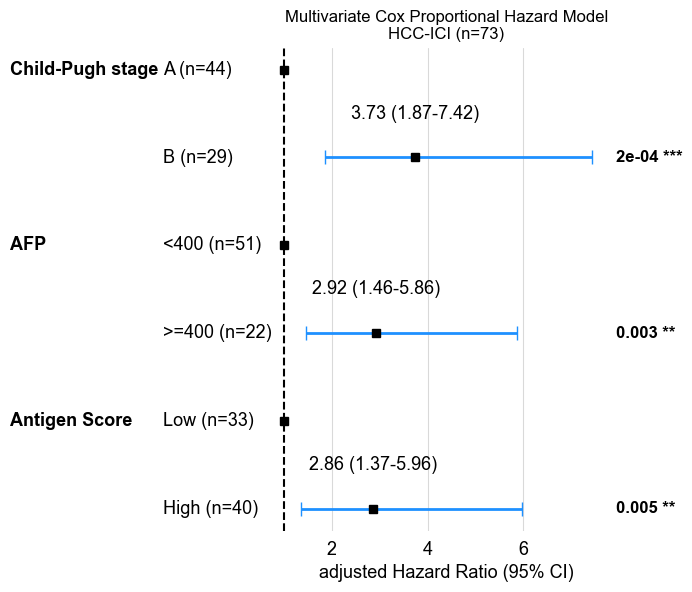

In [121]:
f = forestplot_survival(multivariate_forest_reversed,
           save_path=config.figures_dir,
           suffix_file=f'nestedCV_HCC-ICI_{number_peptides}_scaled',
           save_fig = True,
           figsize=(7, 6),
           title="Multivariate Cox Proportional Hazard Model\nHCC-ICI (n=73)")
f

## Responders vs non responders

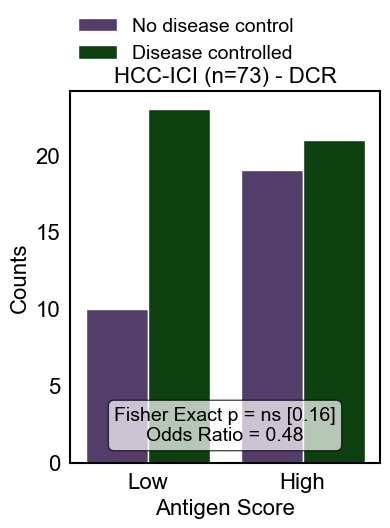

In [145]:
mapping_antigen = {0: 'Low', 1: 'High'}
fontsize = {"title": 16, "xlabel": 16, "ylabel": 16, "xtick": 16, "ytick": 16,"legend": 14, "annotation": 14}
mapping = {1: 'Disease controlled', 0: 'No disease control'}
palette = {
        'Disease controlled': '#054907',  # dark blue
        'No disease control': '#513573'   # dark purple
    }
# Call the function
fig = barplot_counts_fisher_test(
    df=clinical_meta,
    cat_var1='DCR',
    title="HCC-ICI (n=73) - DCR",
    cat_var2='Antigen Score (Dichotomized)',
    legend_title='DCR',
    y_label='Counts',
    x_label='Antigen Score',
    mapping1=mapping,
    mapping2=mapping_antigen,
    figsize=(4, 5.5),
    palette=palette,
    save_path=config.figures_dir,
    suffix_file=f"nestedCV_HCC-ICI_DCR_{number_peptides}_scaled_corrected2",
    fontsize=fontsize
)
fig

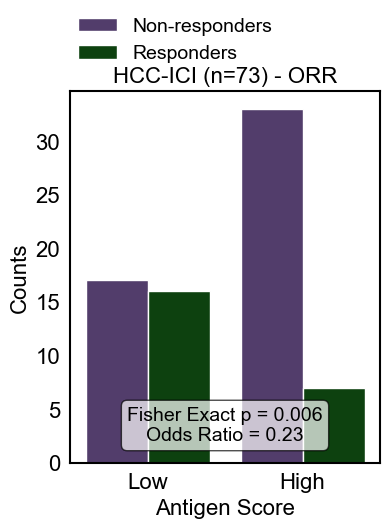

In [144]:
mapping = {1: 'Responders', 0: 'Non-responders'}
palette = {
        'Responders': '#054907',  # dark blue
        'Non-responders': '#513573'   # dark red
    }
# Call the function
fig = barplot_counts_fisher_test(
    df=clinical_meta,
    title="HCC-ICI (n=73) - ORR",
    cat_var1='ORR',
    cat_var2='Antigen Score (Dichotomized)',
    legend_title='ORR',
    y_label='Counts',
    x_label='Antigen Score',
    mapping1=mapping,
    mapping2=mapping_antigen,
    figsize=(4, 5.5),
    palette=palette,
    save_path=config.figures_dir,
    suffix_file=f"nestedCV_HCC-ICI_ORR_{number_peptides}_scaled_corrected2",
    fontsize=fontsize
)
fig

Mann–Whitney Test statistic: 529.0, p-value: 0.221


/home/creyna/miniconda3/envs/ML_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/creyna/miniconda3/envs/ML_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/creyna/miniconda3/envs/ML_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


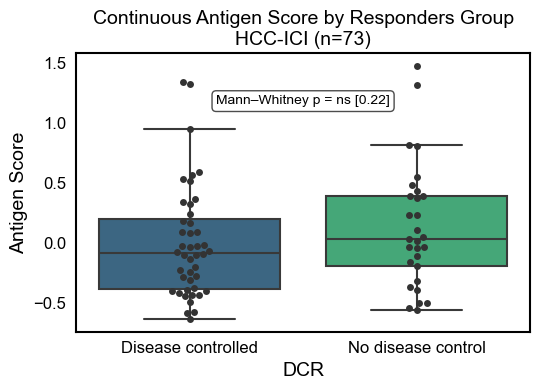

In [126]:
mapping = {1: 'Disease controlled', 0: 'No disease control'}
palette = {
        'Disease controlled': '#155289',  # dark blue
        'No disease control': '#8B0000'   # dark red
    }
mapping_antigen = {0: 'Low', 1: 'High'}

fig = boxplot_compare_distribution_by_category(clinical_meta,
                                               cont_var='Antigen Score',
                                               title="Continuous Antigen Score by Responders Group\nHCC-ICI (n=73)",
                                               cat_var='DCR',
                                               cat_mapping=mapping,
                                               x_label="DCR",
                                               y_label="Antigen Score",
                                               #title="Antigen Score by DCR Group",
                                               figsize=(5.5,4),
                                               # save_path=config.figures_dir,
                                               # suffix_file=f"antigenScore_DCR_{number_peptides}"
                                               )
mapping = {1: 'Responders', 0: 'Non-responders'}
fig

Mann–Whitney Test statistic: 385.0, p-value: 0.024


/home/creyna/miniconda3/envs/ML_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/creyna/miniconda3/envs/ML_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/creyna/miniconda3/envs/ML_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


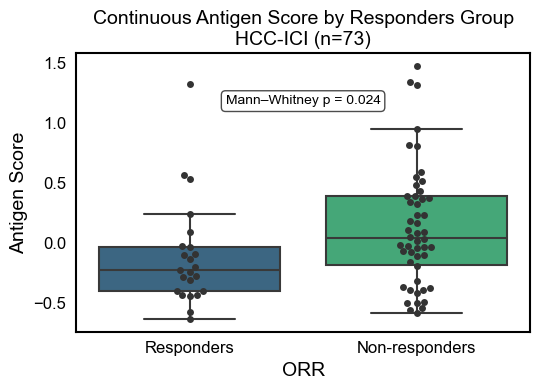

In [127]:
fig = boxplot_compare_distribution_by_category(clinical_meta,
                                               cont_var='Antigen Score',
                                               cat_var='ORR',
                                               title="Continuous Antigen Score by Responders Group\nHCC-ICI (n=73)",
                                               cat_mapping=mapping,
                                               x_label="ORR",
                                               y_label="Antigen Score",
                                               #title="Antigen Score by DCR Group",
                                               figsize=(5.5,4),
                                               #save_path=config.figures_dir,
                                               #suffix_file=f"antigenScore_ORR_{number_peptides}"
                                               )
fig